## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään.

#### Datankäsittely

In [38]:
import os

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata/'

'''datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.05,
    horizontal_flip=True
)

train_dataset = datagen.flow_from_directory(
    image_folder + 'train',
    target_size=(100,100),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)'''

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)



   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


In [40]:
from keras import Sequential, layers, regularizers
from keras.optimizers import Adam

'''model = Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Rescaling(scale=1./255),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  #  layers.Dropout(0.5),
  #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
  #  layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])'''

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

model = Sequential([
    layers.Input(shape=(100,100, 3)),
    data_augmentation,
    layers.Rescaling(scale=1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])




model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │       2,166,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,186,500 (8.34 MB)

 Trainable params: 2,186,500 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
import keras

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [42]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2262 - loss: 5.6709 - val_accuracy: 0.2500 - val_loss: 5.3797
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3364 - loss: 5.2981 - val_accuracy: 0.7250 - val_loss: 5.0045
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6129 - loss: 4.9257 - val_accuracy: 0.8250 - val_loss: 4.6673
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6181 - loss: 4.5928 - val_accuracy: 0.6250 - val_loss: 4.3247
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6259 - loss: 4.2594 - val_accuracy: 0.8250 - val_loss: 4.0122
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7635 - loss: 3.9117 - val_accuracy: 0.9000 - val_loss: 3.7001
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8106 - loss: 3.6005 - val_accuracy: 0.8500 - val_loss: 3.4196
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8010 - loss: 3.3626 - val_accuracy: 0.

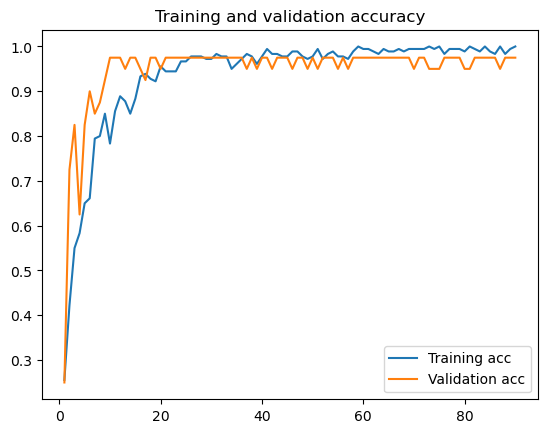

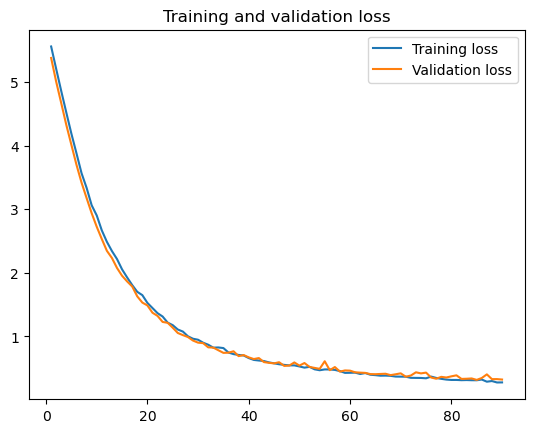

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [45]:
test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.31
Test accuracy: 0.98


In [57]:

from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.layers import Dropout
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam


# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(16, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create the new model
model_vgg16 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_vgg16.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg16.summary()



Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │         147,488 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,862,772 (56.70 MB)

 Trainable params: 148,084 (578.45 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Training VGG16 model

Model training and adding <i><b>early_stopping</b></i> and <i><b>reduce_lr</b></i> callback functions to reduce over fitting.

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


# Train the model
history_vgg16 = model_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6852 - loss: 0.6431 - val_accuracy: 0.9250 - val_loss: 0.3365
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.6514 - loss: 0.7413 - val_accuracy: 0.8500 - val_loss: 0.4105
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7193 - loss: 0.5972 - val_accuracy: 0.8500 - val_loss: 0.4481
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7814 - loss: 0.4974 - val_accuracy: 0.8000 - val_loss: 0.4298
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.7061 - loss: 0.5959 - val_accuracy: 0.8250 - val_loss: 0.4022
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7372 - loss: 0.6342 - val_accuracy: 0.8000 - val_loss: 0.3909
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.8166 - loss: 0.3800 - val_accuracy: 0.8000 - val_loss: 0.3528
Epoch 8/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7464 - loss: 0.5016 - val_accuracy: 0.

In [62]:
# Evaluate the model
test_scores_vgg16 = model_vgg16.evaluate(test_dataset, verbose=0)
print(f"VGG16 Test loss: {test_scores_vgg16[0]:.2f}")
print(f"VGG16 Test accuracy: {test_scores_vgg16[1]:.2f}")

VGG16 Test loss: 0.01
VGG16 Test accuracy: 1.00


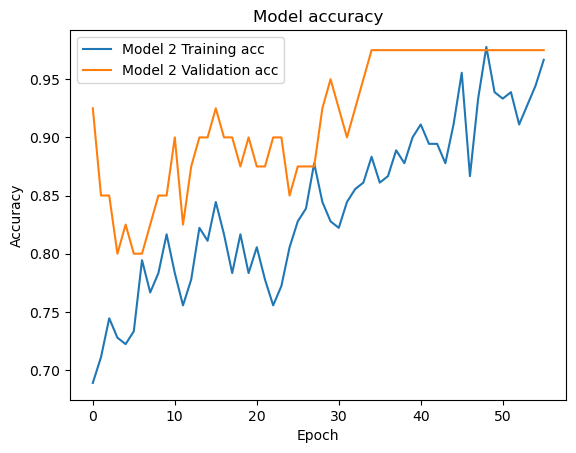

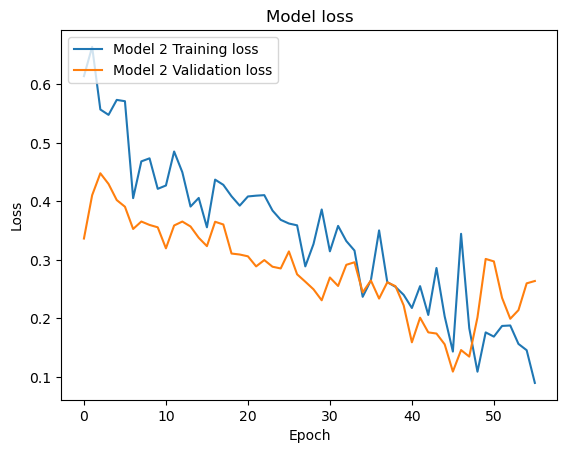

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'], label='Model 1 Training acc')
#plt.plot(history.history['val_accuracy'], label='Model 1 Validation acc')
plt.plot(history_vgg16.history['accuracy'], label='Model 2 Training acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Model 2 Validation acc')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
#plt.plot(history.history['loss'], label='Model 1 Training loss')
#plt.plot(history.history['val_loss'], label='Model 1 Validation loss')
plt.plot(history_vgg16.history['loss'], label='Model 2 Training loss')
plt.plot(history_vgg16.history['val_loss'], label='Model 2 Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()